## Setup

In [1]:
import numpy as np 
import pickle
import pandas as pd
from tqdm import tqdm

import multicam

import pandas as pd


In [2]:
import matplotlib.pyplot as plt


In [3]:
metadata_file = "../../data/processed/tng/tng300-1-table.csv"
tng_snapshot_dir = "../../data/processed/tng/TNG300-1/"  # everything is a host halo
tng_dark_snapshot_dir = "../../data/processed/tng/TNG300-1-Dark/"

trees_file = "../../data/processed/tng/TNG300-1_cut_trees.p"
present_snapfile = tng_snapshot_dir + "TNG300-1_HaloHistory_MBP_snap99.hdf5"

dark_trees_file = "../../data/processed/tng/TNG300-1-Dark_cut_trees.p"
present_dark_snapfile = tng_dark_snapshot_dir + "TNG300-1-Dark_HaloHistory_MBP_snap99.hdf5"

color_file = "../../data/processed/tng/Subhalo_StellarPhot_p07c_cf00dust_res_conv_ns1_rad30pkpc_099.hdf5"


## Do matching

In [5]:
dcat = pd.read_hdf(present_dark_snapfile) # dark matter only
cat = pd.read_hdf(present_snapfile) # hydro

len(dcat), len(cat)


(13000, 13643)

In [17]:
# use a scipy kdtree to match haloes in in the dark matter and hydro catalogs
import scipy.spatial as spatial

# get positions 
pos = np.array(cat[['pos_x', 'pos_y', 'pos_z']])
dpos = np.array(dcat[['pos_x', 'pos_y', 'pos_z']])

# kdtree 
tree = spatial.KDTree(pos)
dtree = spatial.KDTree(dpos)


In [20]:
# find the nearest neighbor in the other catalog
d, indx = tree.query(dpos)
dd, dindx = dtree.query(pos)


In [23]:
len(dindx), len(indx)


(13643, 13000)

In [24]:
# number of bijections 
n_matches = 0
for ii in range(len(cat)):
    if ii == indx[dindx[ii]]:
        n_matches += 1
n_matches


12695

(array([  3.,  25.,  94., 138., 218., 316., 381., 436., 472., 589., 575.,
        573., 590., 590., 583., 544., 541., 464., 385., 451., 353., 334.,
        303., 289., 257., 258., 192., 190., 173., 159., 140., 143., 141.,
        112.,  91.,  97.,  88.,  81.,  70.,  67.,  56.,  58.,  71.,  41.,
         49.,  41.,  33.,  32.,  28.,  22.,  27.,  30.,  30.,  19.,  24.,
         19.,  14.,  19.,  20.,   9.,  13.,  22.,  14.,  13.,  11.,  15.,
         11.,  10.,   8.,  13.,   5.,   7.,   9.,  11.,  13.,   4.,   3.,
          8.,   9.,   5.,   5.,   3.,   4.,   6.,   8.,  10.,   3.,   2.,
          3.,   3.,   5.,   3.,   5.,   3.,   4.,   1.,   3.,   1.,   7.,
          5.]),
 array([  0.,   2.,   4.,   6.,   8.,  10.,  12.,  14.,  16.,  18.,  20.,
         22.,  24.,  26.,  28.,  30.,  32.,  34.,  36.,  38.,  40.,  42.,
         44.,  46.,  48.,  50.,  52.,  54.,  56.,  58.,  60.,  62.,  64.,
         66.,  68.,  70.,  72.,  74.,  76.,  78.,  80.,  82.,  84.,  86.,
         88.,  90.,  9

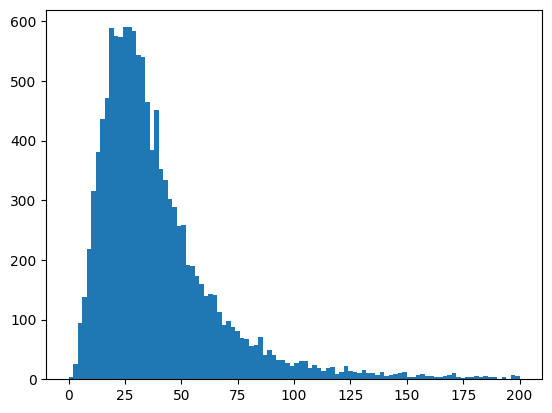

In [35]:
# plot the distribution of distances between matched haloes
plt.hist(dd, bins=100, range=(0, 200))


1073

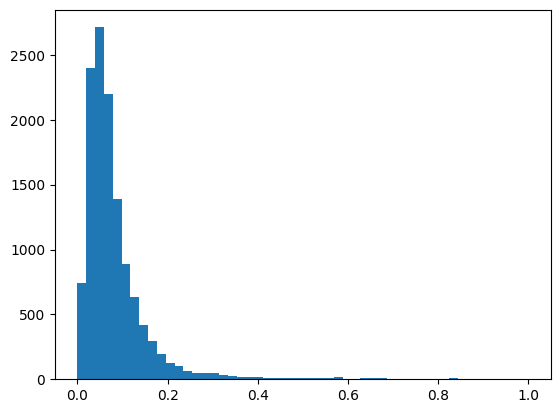

In [48]:
# plot virial radius to distance
plt.hist(dd/cat['Rvir'], bins=51, range=(0, 1))

sum(dd / cat['Rvir'] > 1)


In [49]:
# keep only bijectively matched haloes

# number of bijections 
keep = []
for ii in range(len(cat)):
    if ii == indx[dindx[ii]]:
        keep.append(ii)
keep = np.array(keep)

dkeep = [] 
for ii in range(len(dcat)):
    if ii == dindx[indx[ii]]:
        dkeep.append(ii)
dkeep = np.array(dkeep)

cat = cat.iloc[keep]
dcat = dcat.iloc[dkeep]

len(cat), len(dcat)


(12695, 12695)

In [54]:
sum(dd[keep] / cat['Rvir'] > 1)


9

## Extract other properties and predict

In [7]:
from multicam.tng.utils import setup_mah_and_cat, get_msmhmr, get_color, match_dm_and_hydro_cat, SNAPS


In [8]:
info = setup_mah_and_cat(trees_file, present_snapfile, metadata_file, SNAPS)
dinfo = setup_mah_and_cat(dark_trees_file, present_dark_snapfile, metadata_file, SNAPS)


/Users/imendoza/code/nbody-relaxed/multicam/tng/utils.py:20: RuntimeWarning: divide by zero encountered in log10
  return np.where(gmass > 0, np.log10(gmass * 1e10 / TNG_H), 0)


In [13]:
cat, mah, mvir, scales = info['present_cat'], info['m_peak'], info['gmass'], info['scales']
dcat, dmah, dmvir, _dscales = dinfo['present_cat'], dinfo['m_peak'], dinfo['gmass'], dinfo['scales']

assert np.all(scales == _dscales)


In [17]:
# get colors 
color = get_color(color_file, cat) 
gr = color['sdss_g'].values - color['sdss_r'].values


In [20]:
# get mean stellar mass - halo mass deviation 
msmhmr, _  = get_msmhmr(cat, mvir)


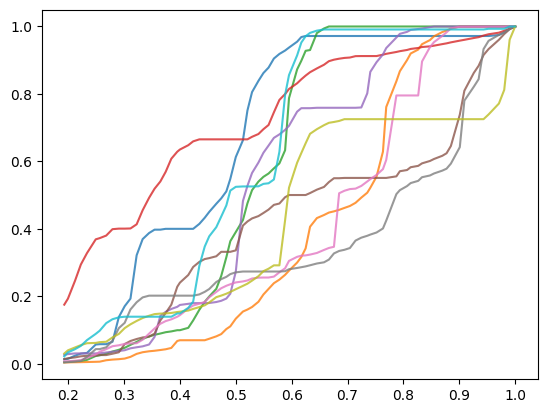

In [15]:
# plot 10 random m_peaks as a function of scale 
for ii in range(10):
    idx = np.random.randint(0, len(mah))
    plt.plot(scales, mah[idx], '-', alpha=0.8
    );
